# Handle missing values in Categorical Features

We will be use the [Classified Ads for Cars](https://www.kaggle.com/mirosval/personal-cars-classifieds) dataset to predict the price of the ADs. This dataset is full of missing values, categorical and not. Our aim will be a simple Regression problem. To archieve this we will focus on a particular categorical feature, the **maker**.

* **Replace** missing values with the *most frequent values*. It could lead to an unbalanced dataset.
* **Delete** rows with null values. It could lead to a loss of too many useful informations.
* **Predict** values using a Classifier Algorithm (supervised or unsupervised)


## Steps
* **Show Raw Data**: let's see how raw data looks like.
* **Some Feature Engineering**: data cleaning and extraction of new features.
* **Models**: we will deal missing values comparing different techniques.
* **Conclusions**

In [30]:
# Importing Libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

## Show Raw Data
Let's see how raw data looks like

In [31]:
import zipfile

filename = "cars.csv"

with zipfile.ZipFile(filename + ".zip", 'r') as zip_ref:
    zip_ref.extractall("")

dtypes = {
    "maker": str, # brand name
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str, # almost never present
    "color_slug": str, # also almost never present
    "stk_year": str,
    "transmission": str, # automatic or manual
    "door_count": str,
    "seat_count": str,
    "fuel_type": str, # gasoline, diesel
    "date_created": str, # when the ad was scraped
    "date_last_seen": str, # when the ad was last seen. Dataset policy was to remove all ads older than 60 days
    "price_eur": float} # list price converted to EUR

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [32]:
# Missing values
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [33]:
# Here we can see strage data, like the Min() and the Max() of some features
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,3.19033e+06,3.18233e+06,2.8095e+06,2.99804e+06,3.55291e+06
mean,115814,2000.87,2043.96,98.468,1.62581e+06
std,342251,81.7259,1973.96,49.0731,2.02562e+09
min,0,0,0,1,0.04
25%,18800,2004,1400,68,1295.34
50%,86415,2009,1798,86,7364.91
75%,158025,2013,1997,110,16284.2
max,1e+07,2017,32767,2237,2.70615e+12


## Some Feature Engineering

In [34]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 150.00]
# df = df[df["mileage"] < 800000.00]
# df = df[df["engine_displacement"] < 3000.00]
# df = df[df["engine_power"] < 1000.00]


# Manufacture Year
year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].\
groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# Engine Power
min_engine_power = 50
average = df.loc[df["engine_power"] >= min_engine_power].\
groupby(["maker", "model"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_power"] < min_engine_power, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Displacement
min_engine_displacement = 600
average = df.loc[df["engine_displacement"] >= min_engine_displacement].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < min_engine_displacement, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["avg_engine_displacement"])
df = df[df['engine_displacement'].notna()]

# Mileage
features_to_fillna = ["mileage"]
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduction of the mean
    df[feature].fillna(replace_with,inplace=True)


In [35]:
# let's transform str dates in datetimes and creare a new feature with the duration of ADs
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

**Replace** missing values with the *most frequent values*

In [36]:
# 
features_to_fillna = ["door_count", "seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduction of the median
    df[feature].fillna(replace_with,inplace=True)             # replace null
    
df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)

**Delete** rows with null values.

In [37]:
#
df = df[df['fuel_type'].notna()]
#df = pd.get_dummies(df,columns=["fuel_type"])
size_mapping = {"diesel":0,"gasoline":1}
df["fuel_type"] = df["fuel_type"].map(size_mapping)

df = df[df['transmission'].notna()]
# df = pd.get_dummies(df,columns=["transmission"])
size_mapping = {"man":0,"auto":1}
df["transmission"] = df["transmission"].map(size_mapping)


In [59]:
# drop features
features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_displacement","avg_engine_power"]
df = df.drop(features_to_drop, axis="columns")
df.head()

KeyError: "['model' 'body_type' 'color_slug' 'stk_year' 'avg_manufacture_year'\n 'date_created' 'date_last_seen' 'avg_engine_displacement'\n 'avg_engine_power'] not found in axis"

In [39]:
# Missing values
print(df.isna().sum())

maker                  212897
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
fuel_type                   0
price_eur                   0
ad_duration                 0
seat_str_large              0
seat_str_medium             0
seat_str_small              0
dtype: int64


Almost there! Now we just have to handle the **maker** feature, and we will do it with four different ways. Then, for each of them, we will create a simple model of Linear Regression for the prediction.

* **1st Model**: Delete the entire column *Maker*.
* **2nd Model**: Replace values with the mode.
* **3rd Model**: Delete rows with null values.
* **4th Model**: Predict the missing values with the RandomForestClassifier.

In [40]:
mse_list = []
r2_score_list = []
num_records_list = []

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

def plot_regression(Y_test, Y_pred):
    x = Y_test
    y = Y_pred

    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.plot(x, y, 'o')

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x + b)

## Delete the entire column *Maker*.
Our first try will be to create a model without the column *Maker*, leaving the number of rows unchanged. This "no-deal" practice is needed when the large amount of missing data threatens to invalidate the entire feature.

With this scenario we will probably have the worst results on metrics.
 

In [41]:
df_no_maker = df.copy()
# drop of the feature maker
df_no_maker = df_no_maker.drop("maker", axis="columns")

df_no_maker = remove_outliers(df_no_maker)

X = df_no_maker.drop("price_eur", axis=1).values
Y = np.log1p(df_no_maker["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_no_maker.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+ str(df_no_maker.shape[0]))

MSE: 0.12932149324253736
R2 score: 0.8543623748000924
Remaining rows: 853230


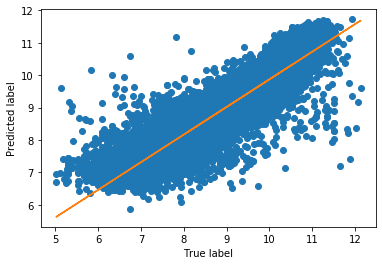

In [42]:
plot_regression(Y_test, Y_pred)

In [43]:
df_no_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small
count,853230,853230,853230,853230,853230,853230,853230,853230,853230,853230
mean,86884.6,2009.56,1807.35,97.9722,0.503243,13310.3,45.2175,0,1,0
std,79025.4,5.12763,565.215,37.6439,0.49999,11056.7,47.5425,0,0,0
min,0,1993,600,50,0,150.04,0,0,1,0
25%,16571,2006,1397,70,0,5403.4,10,0,1,0
50%,73494,2011,1689,90,1,10990,30,0,1,0
75%,139778,2014,1995,115,1,18022.3,61,0,1,0
max,793970,2016,5826,251,1,230009,180,0,1,0


## Replace missing values with the most frequent data.
A certainly more effective method is to assign the missing values with the most frequent data, the mode. But be careful that this could lead to an unbalanced dataset, in case the missing values are a considerable number.


In [44]:
df_replace_mode = df.copy()

replace_with = df_replace_mode["maker"].mode()             # deduction of the mode
df_replace_mode[feature].fillna(replace_with,inplace=True) # replace null

df_replace_mode = pd.get_dummies(df_replace_mode,columns=["maker"])

df_replace_mode = remove_outliers(df_replace_mode)

X = df_replace_mode.drop("price_eur", axis=1).values
Y = np.log1p(df_replace_mode["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_replace_mode.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_replace_mode.shape[0]))

MSE: 0.10705120590558774
R2 score: 0.864996371390437
Remaining rows: 187254


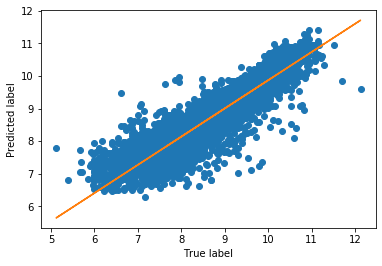

In [45]:
plot_regression(Y_test, Y_pred)

## Delete rows with null values.
Another option is to delete rows that have null values. The certainty here is to lose valuable information from data,

therefore it is necessary to evaluate the trade off with the loss of information

In [46]:
df_del_rows = df.copy()

df_del_rows = df_del_rows[df_del_rows['maker'].notna()]
df_del_rows = pd.get_dummies(df_del_rows,columns=["maker"])

df_del_rows = remove_outliers(df_del_rows)

X = df_del_rows.drop("price_eur", axis=1).values
Y = np.log1p(df_del_rows["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_del_rows.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_del_rows.shape[0]))

MSE: 0.09339606980486992
R2 score: 0.8878627108496644
Remaining rows: 227196


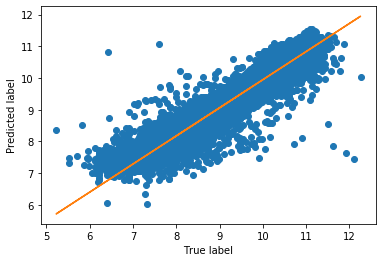

In [47]:
plot_regression(Y_test, Y_pred)

In [48]:
df_del_rows.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
count,227196,227196,227196,227196,227196,227196,227196,227196,227196,227196,...,227196,227196,227196,227196,227196,227196,227196,227196,227196,227196
mean,101527,2009.39,2216.2,128.25,0.354359,19247.9,44.3485,0,1,0,...,0,0,0,0,0,0,0,0,0,0
std,84356.7,5.21189,589.574,40.8391,0.47832,13859.7,46.8835,0,0,0,...,0,0,0,0,0,0,0,0,0,0
min,0,1993,600,51,0,166.54,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25%,26058,2006,1968,100,0,8893.3,10,0,1,0,...,0,0,0,0,0,0,0,0,0,0
50%,89000,2011,1995,125,0,17400,30,0,1,0,...,0,0,0,0,0,0,0,0,0,0
75%,157000,2014,2598,150,1,26013.4,61,0,1,0,...,0,0,0,0,0,0,0,0,0,0
max,793970,2016,6020,262,1,230009,180,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Predict the missing values.
The most interesting approach is for sure that of predicting missing values with a classification algorithm. Therefore the portion of the dataset with not-null values will become our reference dataset which will then be divided into test and train.
The model thus created will be used to fill null values through prediction


In [49]:
df_with_maker = df[df['maker'].notna()]
# df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212897 entries, 9 to 1153195
Data columns (total 11 columns):
maker                  0 non-null object
mileage                212897 non-null float64
manufacture_year       212897 non-null float64
engine_displacement    212897 non-null float64
engine_power           212897 non-null float64
fuel_type              212897 non-null int64
price_eur              212897 non-null float64
ad_duration            212897 non-null int64
seat_str_large         212897 non-null uint8
seat_str_medium        212897 non-null uint8
seat_str_small         212897 non-null uint8
dtypes: float64(5), int64(2), object(1), uint8(3)
memory usage: 15.2+ MB


ACCURACY: TRAIN=0.9633 TEST=0.9226
LOG LOSS: 0.2733889234971634


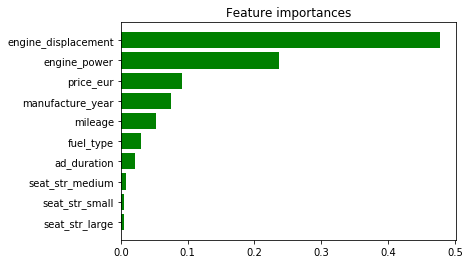

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
# print(indices)

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

#ACCURACY: TRAIN=0.9637 TEST=0.9234
#LOG LOSS: 0.2743385349063343

In [51]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

frames = [df_with_maker, df_no_maker]
df_final = pd.concat(frames)
print(len(df_final.index))
df_final.head()

961576


,maker,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small
0,ford,151000.0,2011.0,2000.0,103.0,0,10584.75,74,1,0,0
1,skoda,143476.0,2012.0,2000.0,81.0,0,8882.31,74,0,1,0
2,bmw,97676.0,2010.0,1995.0,85.0,0,12065.06,74,0,1,0
3,skoda,111970.0,2004.0,1200.0,64.0,1,2960.77,74,0,1,0
4,skoda,128886.0,2004.0,1200.0,64.0,1,2738.71,74,0,1,0


In [52]:
df_no_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small
count,212897,212897,212897,212897,212897,212897,212897,212897,212897,212897
mean,104198,2009.1,1804.08,91.7592,0.459142,12570.7,46.6393,0.0761965,0.888862,0.0349418
std,224582,5.75639,1093.41,37.4466,0.498329,23405,48.4203,0.265313,0.314304,0.183633
min,0,1970,600,50,0,150.04,0,0,0,0
25%,23970,2006,1397,74,0,4922.28,10,0,1,0
50%,84112,2011,1598,81,0,10362.7,32,0,1,0
75%,150150,2014,1968,103,1,16342.4,61,0,1,0
max,1e+07,2016,32000,997,1,2.64737e+06,180,1,1,1


In [53]:
df_with_maker.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small
count,748679,748679,748679,748679,748679,748679,748679,748679,748679,748679
mean,94771.2,2009.29,1990.93,105.941,0.515794,15402.2,44.9929,0.0379869,0.928869,0.0331437
std,236377,5.67976,1344.98,52.1864,0.499751,85858.7,47.3306,0.191165,0.257043,0.179012
min,0,1970,600,50,0,150.04,0,0,0,0
25%,15656,2006,1416,73,0,5514.43,10,0,1,0
50%,73000,2011,1799,94,1,11490.9,30,0,1,0
75%,139000,2014,2143,125,1,19576.8,61,0,1,0
max,1e+07,2016,32000,999,1,5.00296e+07,180,1,1,1


In [62]:
df_final.sort_values(by=['price_eur'], inplace=True, ascending=False)
df_final.head()

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
898823,35200.0,2012.0,1798.0,118.0,1,219900.00,177,0,1,0,...,0,0,0,0,0,0,0,0,0,0
898173,35200.0,2012.0,1798.0,118.0,1,184858.40,12,0,1,0,...,0,0,0,0,0,0,0,0,0,0
855715,33159.0,2012.0,1798.0,118.0,1,184810.51,14,0,1,0,...,0,0,0,0,0,0,0,0,0,0
876386,93500.0,2008.0,1968.0,103.0,0,174862.95,179,0,1,0,...,0,0,0,0,0,0,0,0,0,0
90620,58000.0,2010.0,1968.0,125.0,0,170075.50,61,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [55]:
df_final = pd.get_dummies(df_final,columns=["maker"])

df_final = remove_outliers(df_final)

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))
num_records_list.append(df_final.shape[0])

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
print("Remaining rows: "+str(df_final.shape[0]))

MSE: 0.08113240233720538
R2 score: 0.890940910126298
Remaining rows: 243174


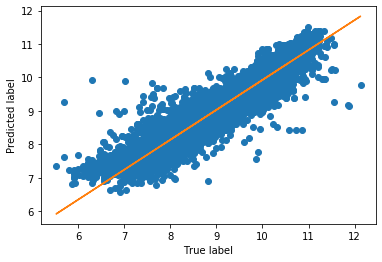

In [56]:
plot_regression(Y_test, Y_pred)

In [57]:
df_final.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,fuel_type,price_eur,ad_duration,seat_str_large,seat_str_medium,seat_str_small,...,maker_opel,maker_porsche,maker_rover,maker_seat,maker_skoda,maker_smart,maker_subaru,maker_suzuki,maker_toyota,maker_volvo
count,243174,243174,243174,243174,243174,243174,243174,243174,243174,243174,...,243174,243174,243174,243174,243174,243174,243174,243174,243174,243174
mean,93688.2,2009.9,1841.73,101.966,0.429787,14919.4,47.7043,0,1,0,...,0,0,0,0,0.459161,0,0,0,0,0
std,82952.1,4.84654,513.882,37.4839,0.495047,11111.9,48.1448,0,0,0,...,0,0,0,0,0.49833,0,0,0,0,0
min,0,1993,670,50,0,166.54,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25%,19182.5,2007,1400,77,0,6608.42,11,0,1,0,...,0,0,0,0,0,0,0,0,0,0
50%,80690,2011,1900,96,0,12847.6,34,0,1,0,...,0,0,0,0,0,0,0,0,0,0
75%,149800,2014,1968,120,1,20422.1,63,0,1,0,...,0,0,0,0,1,0,0,0,0,0
max,790000,2016,5800,251,1,219900,180,0,1,0,...,0,0,0,0,1,0,0,0,0,0


0	Delete the entire column Maker	0.127626	0.856272	853230

1	Replace values with the mode	0.105791	0.866585	187254

2	Delete rows with null values	0.091964	0.889582	227196

3	Predict the missing values	    0.080954	0.892730	243883

## Conclusions

In [61]:
options_list = [
    "Delete the entire column Maker", 
    "Replace values with the mode", 
    "Delete rows with null values", 
    "Predict the missing values"
]

df_metrics = pd.DataFrame({
    "": options_list,
    "MSE": mse_list,
    "R2_score": r2_score_list,
    "# Records": num_records_list
})
df_metrics.head()

,,MSE,R2_score,# Records
0,Delete the entire column Maker,0.129321,0.854362,853230
1,Replace values with the mode,0.107051,0.864996,187254
2,Delete rows with null values,0.093396,0.887863,227196
3,Predict the missing values,0.081132,0.890941,243174
